## Import Modules

In [259]:
import pandas as pd
import numpy as np 
from gensim import models
from lib import weat
import os
import scipy
import matplotlib.pyplot as plt
import importlib
from scipy import stats
import seaborn 
importlib.reload(weat)

## Load Word2Vec and Glove Models

In [2]:
# import and load word2vec model using Google News data
def loadWord2VecModel(file):
    print("Loading word2vec model...")
    w = models.KeyedVectors.load_word2vec_format(file, binary=True)
    print("Finished.")
    return w

In [3]:
# import and load glove model
def loadGloveModel(file):
    print("Loading glove model...")
    f = open(file,'r', encoding='utf-8')
    gloveModel = {}
    for line in f:
        splitLines = line.split(' ')
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

In [ ]:
# load word2vec model
word2vec = loadWord2VecModel('data/GoogleNews-vectors-negative300.bin')

In [4]:
# load Glove model
glove = loadGloveModel('data/glove.840B.300d.txt')

Loading glove model...
2196017  words loaded!


In [5]:
def get_tar_att_arrays(model, t1, t2, a1, a2):
    tar1 = np.array([model[vector] for vector in t1])
    tar2 = np.array([model[vector] for vector in t2])
    att1 = np.array([model[vector] for vector in a1])
    att2 = np.array([model[vector] for vector in a2])
    
    return tar1, tar2, att1, att2

In [260]:
def normal_test(distr):
    k2, p = stats.normaltest(distr)
    alpha = 1e-3
    if p < alpha: 
        return 'Yes'
    else: return 'No'

In [273]:
def get_matrices(filepath, model):

    data_file = pd.read_csv(filepath, sep=',\s*', engine='python',  header=None, index_col=0)
    
    # get targets and attribute labels
    target_names = list(data_file.index)[:2]
    attribute_names = list(data_file.index)[2:]
    
    # get targets and attribute sets
    targets = data_file.loc[target_names]
    attributes = data_file.loc[attribute_names]
    
    # get arrays, one for each set of target and attribute
    tar1 = targets.loc[target_names[0]]
    tar2 = targets.loc[target_names[1]]
    att1 = attributes.loc[attribute_names[0]]
    att2 = attributes.loc[attribute_names[1]]
    
    # remove any NaN values that have been read due to mismatch of columns 
    tar1 = tar1[~pd.isna(tar1)]
    tar2 = tar2[~pd.isna(tar2)]
    att1 = att1[~pd.isna(att1)]
    att2 = att2[~pd.isna(att2)]
        
    # give numpy array of glove word embeddings for targets and attributes
    tar1, tar2, att1, att2 = get_tar_att_arrays(model, tar1, tar2, att1, att2)
    
    return target_names, attribute_names, tar1, tar2, att1, att2

def output_table(model):
    directory = 'targets_attributes_data/'
    
    # instantiate the weta object
    weat_object = weat.Weat()
    effect_size = list()
    p_value = list()
    targets = list()
    normal = list()
    test_distr = list()
    attributes = list()
    
    print('Reading files...\n')

    # loop over all files in the directory
    for filename in os.listdir(directory):
        if not filename.startswith('.'):  # ignore hidden files
            filepath = directory + filename
            print (filepath)

            # retrieve target names and attributes to form the table
            target_names, attribute_names, _, _, _, _ = get_matrices(filepath, model)
            targets.append(target_names)
            attributes.append(attribute_names)

            # retrive the word embeddings for the targets and attributes
            _, _, t1, t2, a1, a2 = get_matrices(filepath, model)
            
            # calculate the effect size 
            effect_size.append(weat_object.effect_size(t1, t2, a1, a2))
            
            # calculate the p-value, test statistic, and permutations
            p_val, test_stat, distr = weat_object.p_value(t1, t2, a1, a2)
            p_value.append(p_val)
            test_distr.append(distr)
            normal.append(normal_test(distr))
                    
    # create a daraframe with the targets, attributes, and effect size
    output_df = pd.DataFrame(data = list(zip(targets, attributes, effect_size, p_value, normal, test_distr)),
                             columns = ['Targets', 'Attributes', 'Effect Size', 'P-Value', 'Normal Distribution?', 'Test Stat Distribution'])
    return output_df

In [275]:
df_glove = output_table(glove)

Reading files...

targets_attributes_data/instruments vs weapons.csv
targets_attributes_data/male vs female names.csv
targets_attributes_data/science vs arts.csv
targets_attributes_data/mental vs physical disease.csv
targets_attributes_data/flowers vs insects.csv
targets_attributes_data/young vs old peoples names.csv
targets_attributes_data/math vs arts.csv
targets_attributes_data/European-American vs African-American names 2.csv
targets_attributes_data/European-American vs African-American names 3.csv
targets_attributes_data/European-American vs African-American names 1.csv


In [276]:
df_glove

,Targets,Attributes,Effect Size,P-Value,Normal Distribution?,Test Stat Distribution
0,"[Instruments, Weapons]","[Pleasant, Unpleasant]",1.540059,0.0000,No,"[-0.1792737006094729, -0.031560432999518995, 0..."
1,"[Male names, Female names]","[Career, Family]",1.873403,0.0000,Yes,"[0.639384583849482, 0.12332036890353398, 0.548..."
2,"[Science, Arts]","[Male terms, Female terms]",1.278036,0.0034,Yes,"[-0.04184841297885003, -0.17285541756455106, 0..."
3,"[Mental disease, Physical disease]","[Temporary, Permanent]",1.535609,0.0010,Yes,"[-0.24071402972383282, -0.0178050137164234, -0..."
4,"[Flowers, Insects]","[Pleasant, Unpleasant]",1.519588,0.0000,No,"[-0.09505345377512067, -0.07467849695902627, 0..."
5,"[Young people’s names, Old people’s names]","[Pleasant, Unpleasant]",1.252668,0.0053,Yes,"[0.10046480401505731, 0.007305253673198564, 0...."
6,"[Math, Arts]","[Male terms, Female terms]",1.089615,0.0173,Yes,"[0.07163854935978946, 0.07424321927626344, 0.0..."
7,"[European American names, African American names]","[Pleasant, Unpleasant]",1.577784,0.0000,No,"[-0.09994763357045798, -0.29935265265736594, -..."
8,"[European American names, African American names]","[Pleasant, Unpleasant]",1.380348,0.0000,No,"[0.10756918612112254, -0.11188941053237689, 0...."
9,"[European American names, African American names]","[Pleasant, Unpleasant]",1.488744,0.0000,No,"[0.9363459090244907, 0.7042990330676386, -0.20..."


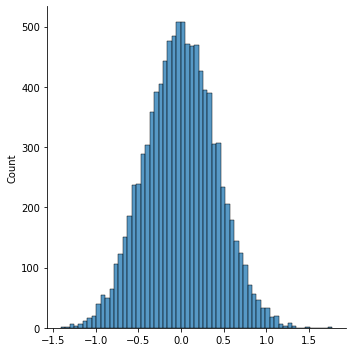

In [282]:
seaborn.displot(df_glove['Test Stat Distribution'][0])

In [283]:
df_glove.to_csv('output/weat_score_glove.csv')